# **WIDHYA MISSION : Uber Data Analysis** 
## **Problem Statement :**You are given six different Uber datasets of different months of 2014 and you will predict the data using artificial neural networks using Keras, Time Series forecasting using statsmodel.api and matplotlib.

# **Import the necessary libraries**


In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import glob
from matplotlib import cm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Reading the dataset and merging it to get relevant information**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Import the dataset and read it
path1 = '/content/drive/MyDrive/uber-raw-data-apr14.csv'
path2 = '/content/drive/MyDrive/uber-raw-data-may14.csv'
path3 = '/content/drive/MyDrive/uber-raw-data-jun14.csv'
path4 = '/content/drive/MyDrive/uber-raw-data-jul14.csv'
path5 = '/content/drive/MyDrive/uber-raw-data-aug14.csv'
path6 = '/content/drive/MyDrive/uber-raw-data-sep14.csv'

df1 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-apr14.csv')
df2 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-may14.csv')
df3 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-jun14.csv')
df4 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-jul14.csv')
df5 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-aug14.csv')
df6 = pd.read_csv('/content/drive/MyDrive/uber-raw-data-sep14.csv')

In [5]:
merged_df = pd.concat([df1,df2,df3,df4,df5,df6],ignore_index=True)

## **Preview of the dataset**

In [6]:
merged_df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [7]:
merged_df.tail()

,Date/Time,Lat,Lon,Base
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764
4534326,9/30/2014 22:58:00,40.7140,-73.9496,B02764


In [9]:
merged_df.shape ##Dimensions of the dataset

(4534327, 4)

# **Feature Engineering**

In [10]:
merged_df.info()  #Information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


In [11]:
merged_df.describe() #Statistics about the dataframe

,Lat,Lon
count,4.534327e+06,4.534327e+06
mean,4.073926e+01,-7.397302e+01
std,3.994991e-02,5.726670e-02
min,3.965690e+01,-7.492900e+01
25%,4.072110e+01,-7.399650e+01
50%,4.074220e+01,-7.398340e+01
75%,4.076100e+01,-7.396530e+01
max,4.211660e+01,-7.206660e+01


## **Spliting Dataset and five more columns: Date, Month, Only_date, Days of week , and Hour**

In [19]:
 merged_df.Timestamp = pd.to_datetime(merged_df['Date/Time'],format='%m/%d/%Y %H:%M:%S')

In [21]:
merged_df['date_only'] = merged_df.Timestamp.dt.date
merged_df['date'] = merged_df.Timestamp
merged_df['month'] = merged_df.Timestamp.dt.month
merged_df['dow_num'] = merged_df.Timestamp.dt.dayofweek
merged_df['dow_name'] = merged_df.Timestamp.dt.day_name()
merged_df['month_day_num'] = merged_df.Timestamp.dt.day
merged_df['hours'] = merged_df.Timestamp.dt.hour


# **Exploratory Data Analysis**

## **Analyzing the peak days in terms of trips**

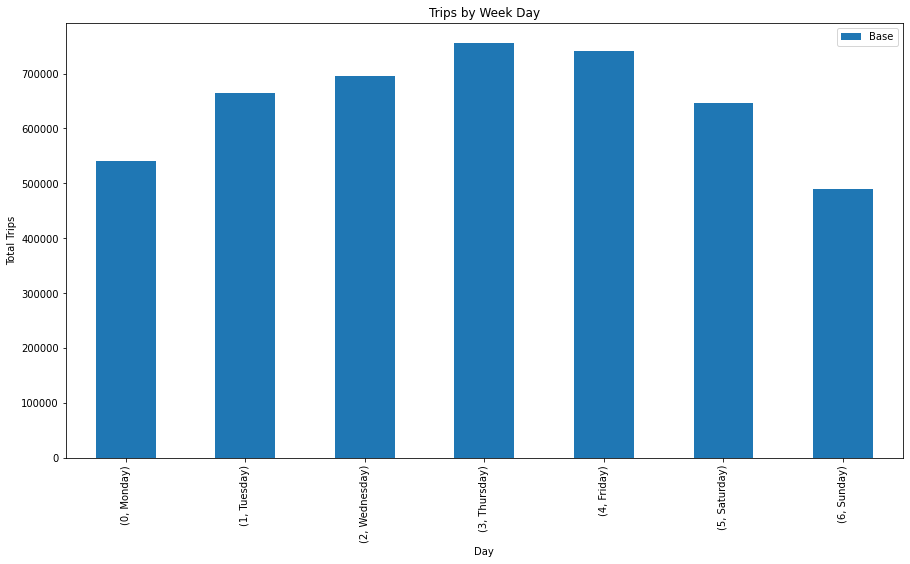

In [24]:
merged_df.groupby(pd.Grouper(key='dow_name')).count()

uber_weekdays = merged_df.pivot_table(index=['dow_num','dow_name'],values='Base', aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(15,8))
plt.ylabel('Total Trips')
plt.xlabel('Day')
plt.title('Trips by Week Day');


Here we can notice that the larest number of uber pickups were done on Thurdays, Fridays and Wednesdays

# **Analysis of the peak hours**

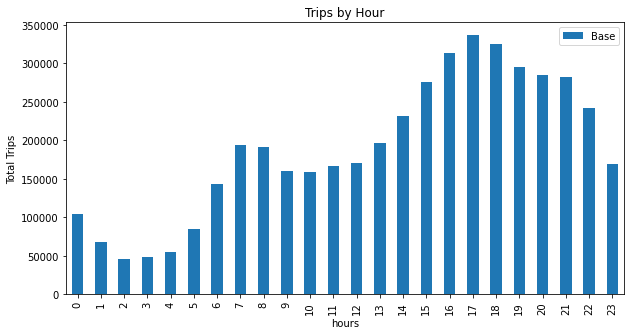

In [26]:
uber_hour = merged_df.pivot_table(index=['hours'], values='Base', aggfunc='count')
uber_hour.plot(kind='bar', figsize=(10,5))
plt.ylabel('Total Trips')
plt.title('Trips by Hour');

From here we can notice that peak hours of booking a cab are in between in the evening from 4pm to 8pm. We can also see that more cabs are booked in evenings compared to morning

# **Base**

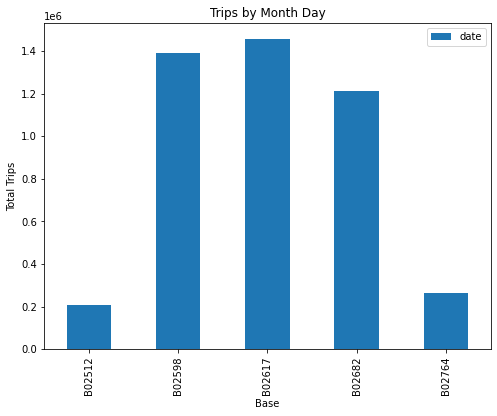

In [27]:
merged_df.groupby(pd.Grouper(key='Base')).count()

uber_monthdays = merged_df.pivot_table(index=['Base'], values='date' ,
                                  aggfunc='count')
uber_monthdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Trips')
plt.title('Trips by Month Day');

Here we can notice that Base B02617 provided most cab which is followed by B02598

## **Split the dataset**

As per requirements and as we having a very large dataset of 4.5 million+ values. We will use 80-10 split

In [30]:
merged_df= merged_df.drop(columns = ['month','dow_num','Base', 'dow_name', 'month_day_num', 'hours'])

In [31]:
merged_df.head()

,Date/Time,date_only,date
0,4/1/2014 0:11:00,2014-04-01,2014-04-01 00:11:00
1,4/1/2014 0:17:00,2014-04-01,2014-04-01 00:17:00
2,4/1/2014 0:21:00,2014-04-01,2014-04-01 00:21:00
3,4/1/2014 0:28:00,2014-04-01,2014-04-01 00:28:00
4,4/1/2014 0:33:00,2014-04-01,2014-04-01 00:33:00


## **Implementation Of Time Series Forecasting**

The df uber_dates is the grouping of the above dataset on daily basis with timestamp of only date. This datadeame is used to for univariate Time Series Forecasting.

In [32]:
uber_dates=merged_df.groupby(pd.Grouper(key='date_only')).count()
uber_dates= uber_dates.drop(columns = ['date'])
print(uber_dates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2014-04-01 to 2014-09-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Date/Time  183 non-null    int64
dtypes: int64(1)
memory usage: 2.9+ KB
None


In [34]:
uber_dates_d= uber_dates.drop(columns = ['Date/Time'])
uber_dates_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2014-04-01 to 2014-09-30
Empty DataFrame

### **Calculating 90 % of the data**

In [36]:
round(0.9*len(uber_dates))

165

## **Data Splitting**

In [37]:
train_ts = uber_dates[:][:165]                     #split is 90-10
test_ts = uber_dates[:][166:]
test_ts_d = uber_dates_d[:][166:]

## **Preview of training and testing dataset**

In [38]:
train_ts.tail()

,Date/Time
date_only,
2014-09-08,30360
2014-09-09,34560
2014-09-10,35910
2014-09-11,36439
2014-09-12,39540


In [39]:
test_ts.head()

,Date/Time
date_only,
2014-09-14,28122
2014-09-15,29454
2014-09-16,36092
2014-09-17,35531
2014-09-18,40274


## **Analysis Of Trips Monthwise**

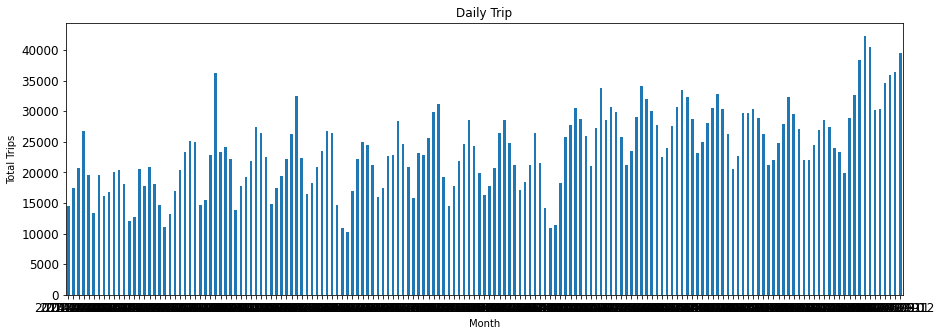

In [42]:
train_ts['Date/Time'].plot(kind = 'bar',figsize=(15,8), title= 'Daily Trip', fontsize=12)
test_ts['Date/Time'].plot(figsize=(15,5), title= 'Daily Trip', fontsize=12)
plt.ylabel('Total Trips')
plt.xlabel('Month')
plt.show()

## **Implementation Of Holt's Winter Seasonal Method**

In [44]:
hat_avg = test_ts.copy()
fit1 = ExponentialSmoothing(np.asarray(train_ts['Date/Time']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
hat_avg['Holt_Winter'] = fit1.forecast(len(test_ts))

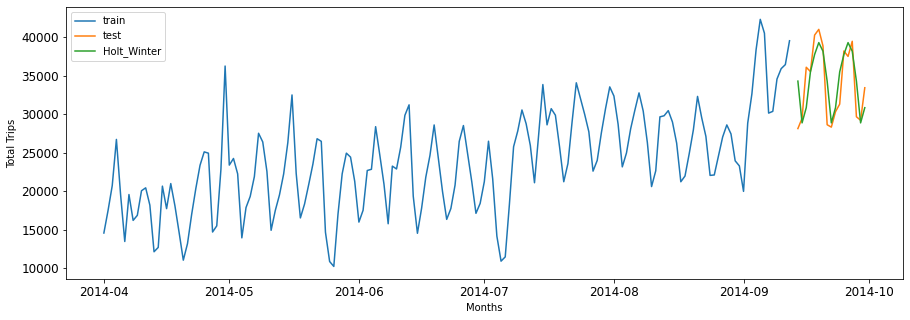

In [46]:
plt.figure(figsize=(15,5))
train_ts['Date/Time'].plot(kind='line',figsize=(15,8),fontsize=12,label='train')
test_ts['Date/Time'].plot(figsize=(15,5),fontsize=12,label='test')
plt.plot(hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.ylabel('Total Trips')
plt.xlabel('Months')
plt.show()

This model gives best accuracy so far and we can notice from the above plot that the predicted Holt winter graph is almost overlapping with the actual test dataset available to us.

### **Implemenation Of Holt's Linear Trend Method**

<Figure size 1600x800 with 0 Axes>

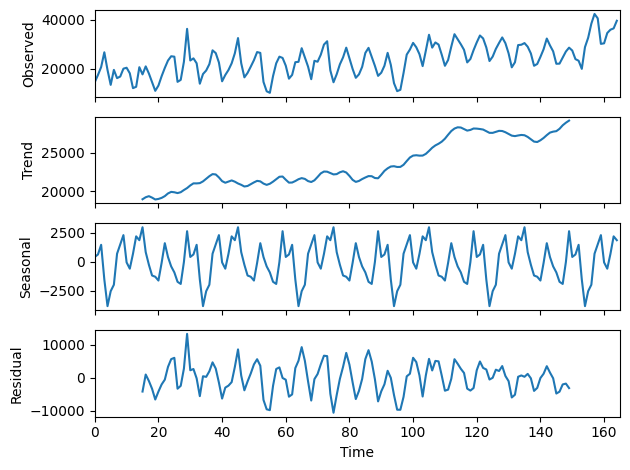

In [47]:
plt.style.use('default')
plt.figure(figsize = (16,8))
sm.tsa.seasonal_decompose(train_ts['Date/Time'].values,freq=30).plot()
result = sm.tsa.stattools.adfuller(uber_dates['Date/Time'])
plt.show()

## **Holt Linear Model Prediction**

In [49]:
hat_avg_1 = test_ts.copy()

fit1 = Holt(np.asarray(train_ts['Date/Time'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
hat_avg_1['Holt_linear'] = fit1.forecast(len(test_ts))


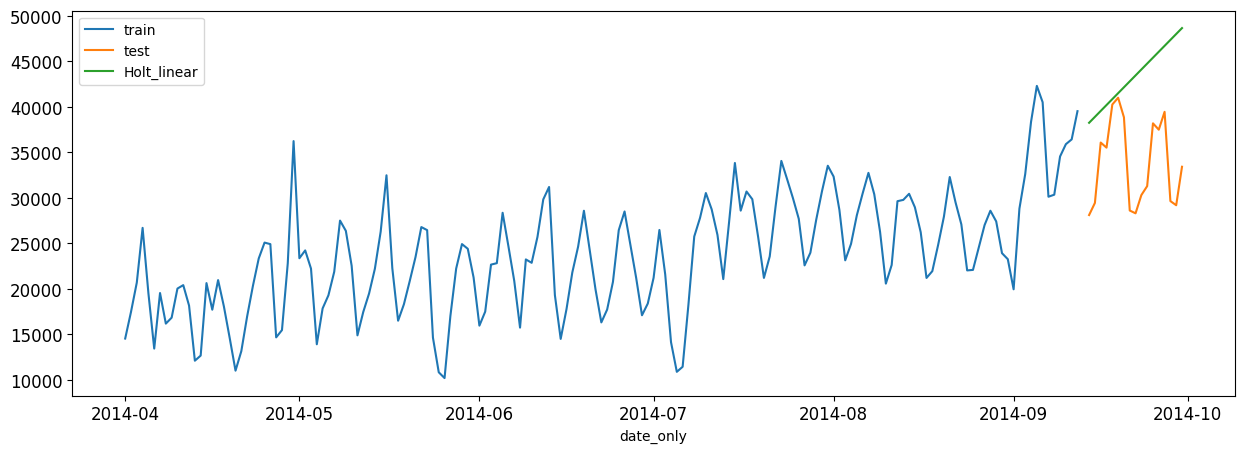

In [52]:
plt.figure(figsize=(16,5))
train_ts['Date/Time'].plot(kind='line',figsize=(15,8),fontsize=12,label='train')
test_ts['Date/Time'].plot(figsize=(15,5),fontsize=12,label='test')
plt.plot(hat_avg_1['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

# **Implemenation Of the ARIMA Model**

In [53]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from matplotlib.pylab import rcParams

## **Rolling Mean and STD**

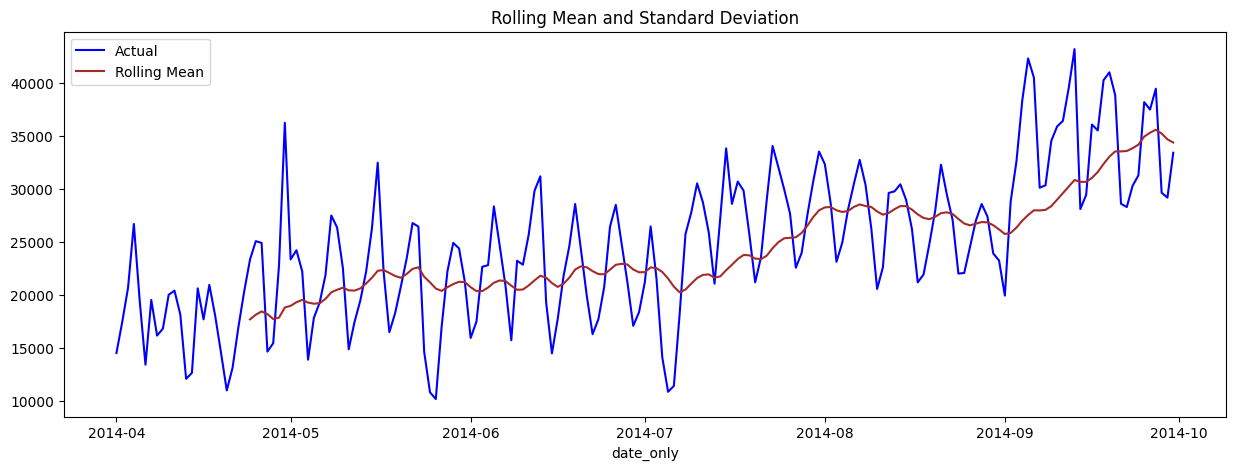

In [54]:
rcParams['figure.figsize']=(15,5)
rolmean = uber_dates['Date/Time'].rolling(24).mean()
rolstd = uber_dates['Date/Time'].rolling(24).std()
        
#Plot rolling Statistics
uber_dates['Date/Time'].plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
#.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

# **Removing Trends**

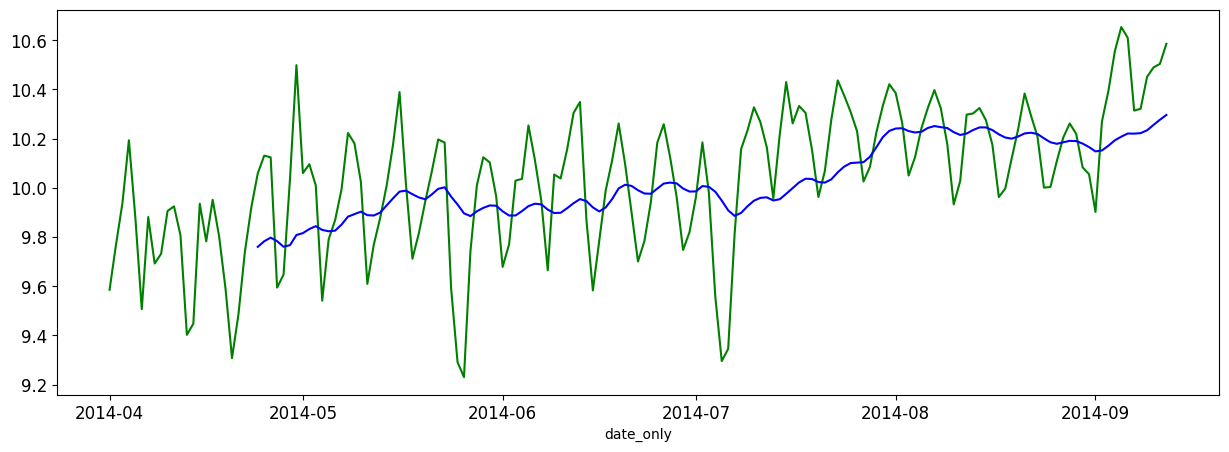

In [57]:
Train_log = np.log(train_ts['Date/Time'])
valid_log = np.log(test_ts['Date/Time'])
moving_avg = Train_log.rolling(24).mean()
Train_log.plot(kind='line',figsize=(15,8),fontsize=12, color = 'green', label='Training_log')
moving_avg.plot(figsize=(15,5),fontsize=12, color = 'blue', label='Moving_avg')

## **Use Of differencing to make series stable and able to eliminate trend**

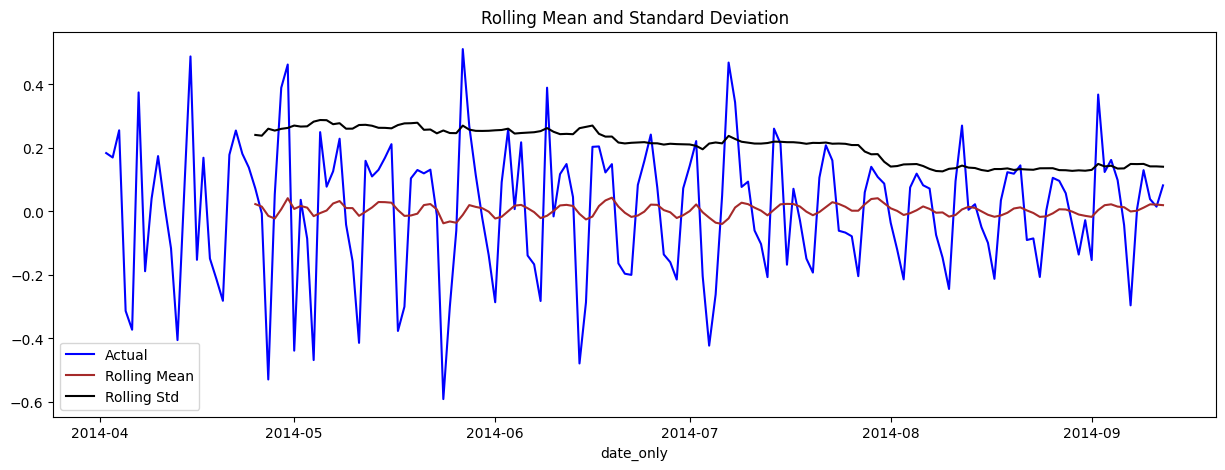

In [58]:
train_log_diff = Train_log - Train_log.shift(1)


rolmean = train_log_diff.rolling(24).mean()
rolstd = train_log_diff.rolling(24).std()

#Plot rolling Statistics
train_log_diff.plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
rolstd.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

## **Removal Of Seasonality**

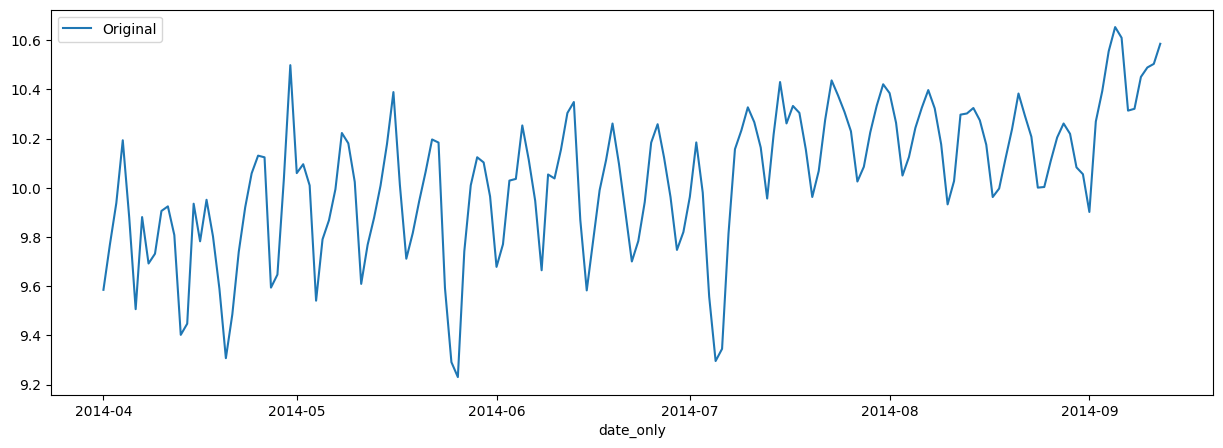

In [61]:
decomposition = seasonal_decompose(pd.DataFrame(Train_log)['Date/Time'].values, freq = 24)
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize = (15,5))
Train_log.plot(kind='line', label = 'Original')
plt.legend(loc = 'best')

## **Stationarity of residuals and visualising it**

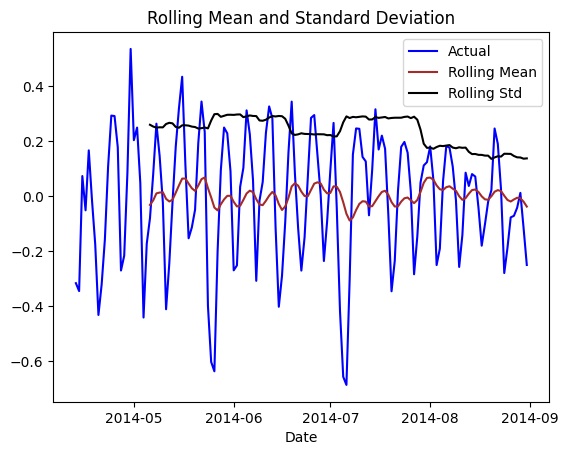

In [62]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['Date'] = Train_log.index
train_log_decompose.set_index('Date', inplace = True)
train_log_decompose.dropna(inplace = True)

from matplotlib.pylab import rcParams
rolmean = train_log_decompose[0].rolling(24).mean()
rolstd = train_log_decompose[0].rolling(24).std()

#Plot rolling Statistics
train_log_decompose[0].plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
rolstd.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

In [63]:
from statsmodels.tsa.stattools import acf, pacf   ##Importing statsmodel

lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method= "ols")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


# **AR Model**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


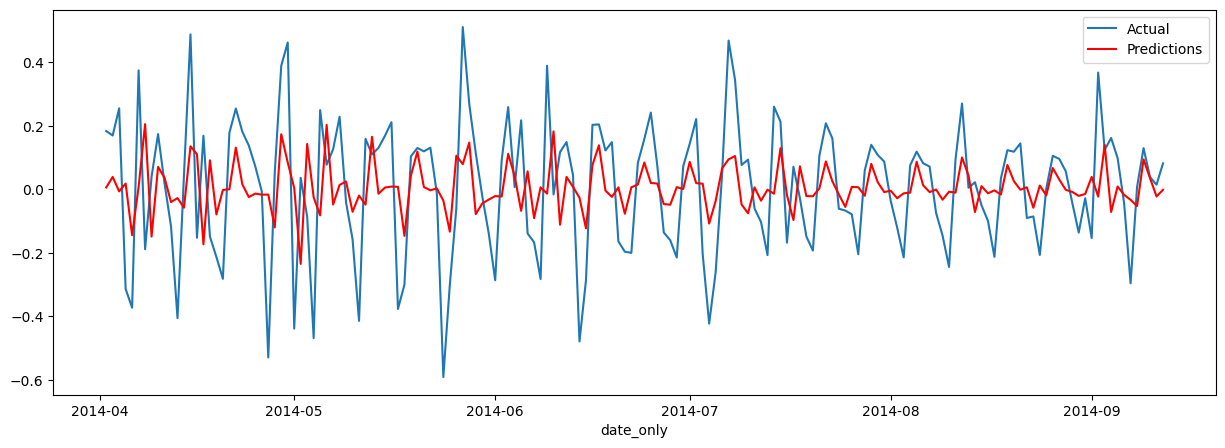

In [64]:
plt.figure(figsize = (15,5))
model = ARIMA(Train_log, order = (2,1,0))  
results_AR = model.fit(disp=-1)
train_log_diff.dropna().plot(kind='line', label = "Actual")
results_AR.fittedvalues.plot(kind='line', color = 'red', label = 'Predictions')
plt.legend(loc = 'upper right')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


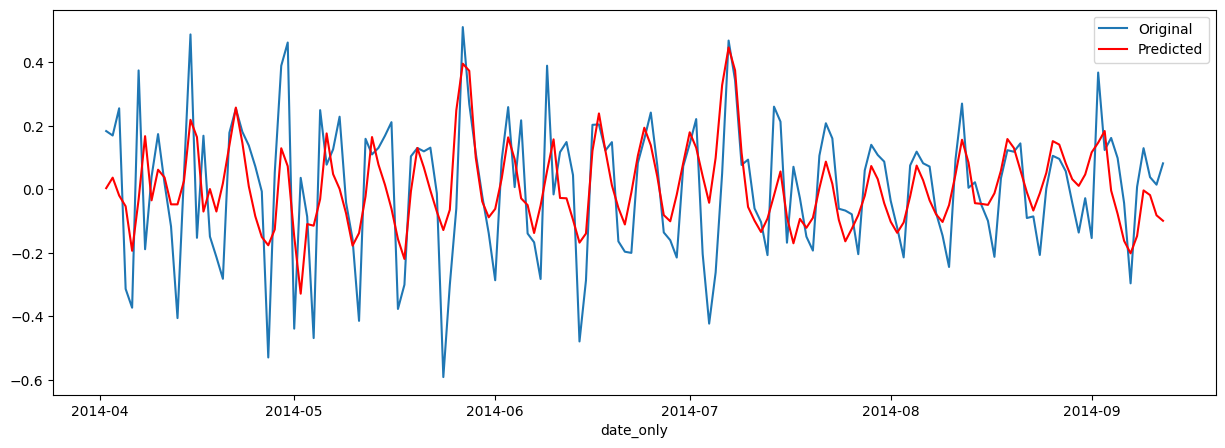

In [66]:
plt.figure(figsize = (15,5))
model = ARIMA(Train_log, order = (2,1,1))
results_ARIMA = model.fit(disp=-1)
train_log_diff.dropna().plot(kind='line',  label='Original')
results_ARIMA.fittedvalues.plot(kind='line', color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

## **ARIMA Model Prediction Results**

In [69]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Date/Time'])[0], index = given_set.index)
    #predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_base)
    
    plt.plot(given_set['Date/Time'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Date/Time']))/given_set.shape[0]))
    plt.show()

In [70]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Date/Time'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Date/Time']))/given_set.shape[0]))
    plt.show()

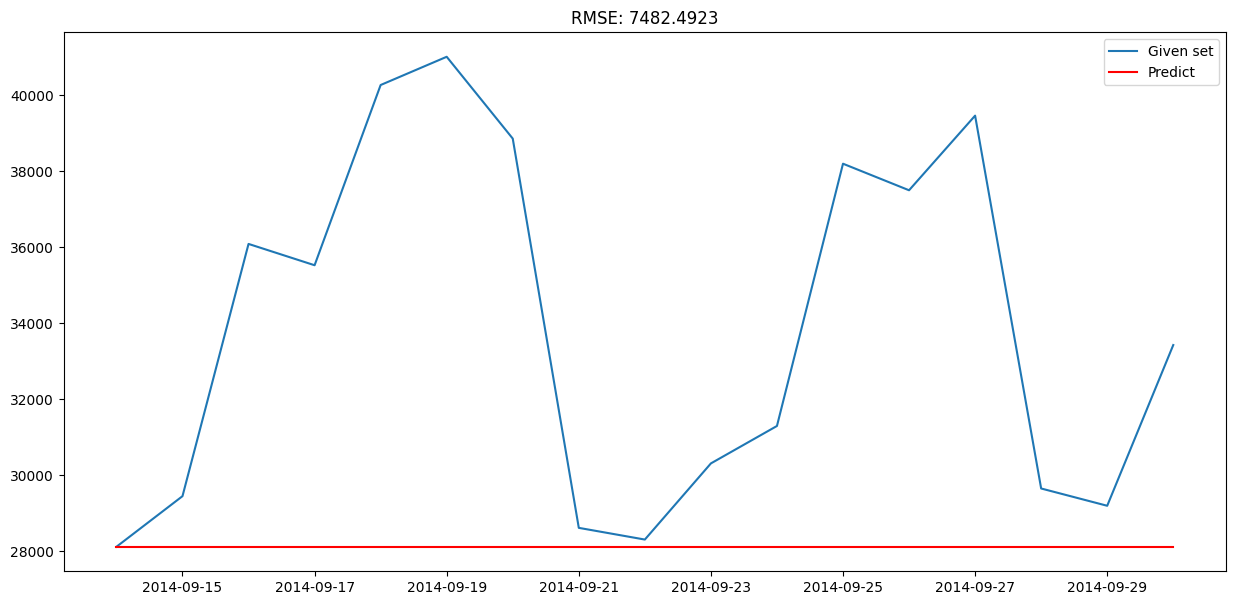

In [73]:
ARIMA_predict_diff=results_ARIMA.predict(len(train_ts))

plt.figure(figsize = (15,7))
check_prediction_diff(ARIMA_predict_diff, test_ts)

In [74]:
ARIMA_predict_diff.shape 

test_ts.shape

(17, 1)

## The AR model has a huge RMSE value thus showing that this model is not suitable for our dataset

## **Implemenation Of Simple Exponential Smoothing**

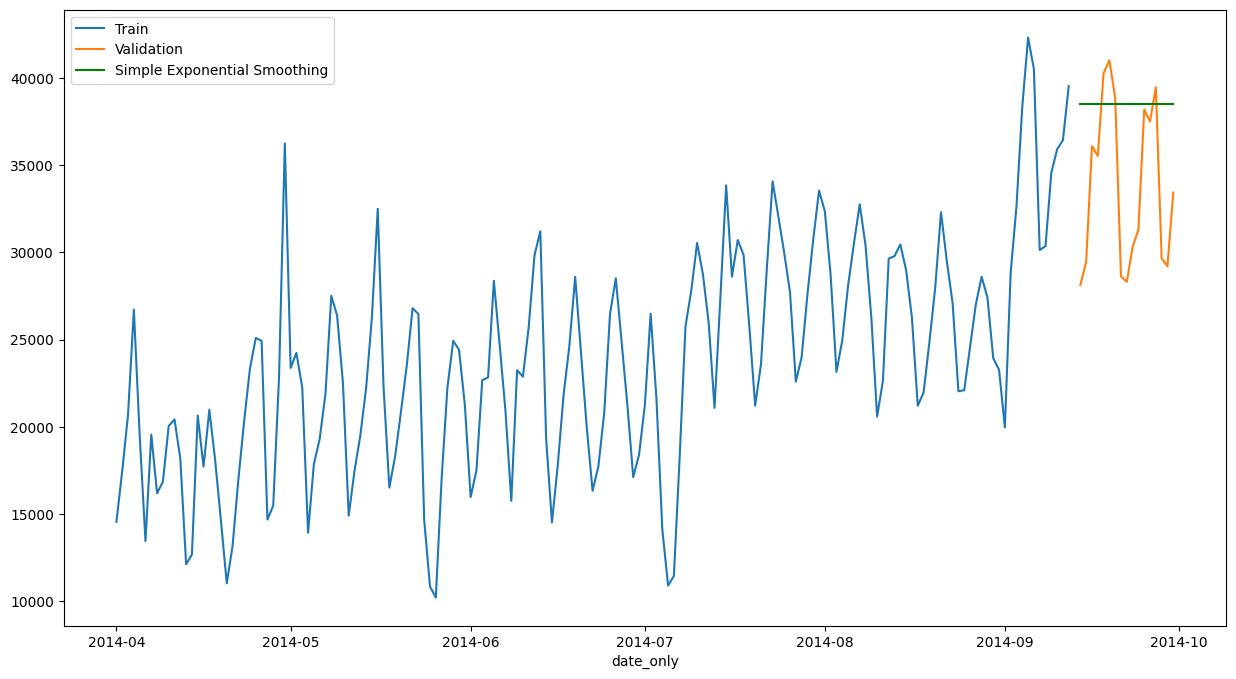

In [76]:
hat_avg = test_ts.copy()
fit2 = SimpleExpSmoothing(np.asarray(train_ts['Date/Time'])).fit(smoothing_level = 0.7,optimized = False)
hat_avg['SES'] = fit2.forecast(len(test_ts))
plt.figure(figsize =(15,6))
train_ts['Date/Time'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['Date/Time'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['SES'], label = 'Simple Exponential Smoothing',color='green')
plt.legend(loc = 'best')

## **RMSE Error For Simple Exponential Smoothing**

In [78]:
hat=hat_avg['SES'].values.tolist()
rmse = sqrt(mean_squared_error(test_ts['Date/Time'],hat))
rmse

6535.680208468773

## **Moving Average Forecast with 10 observations**

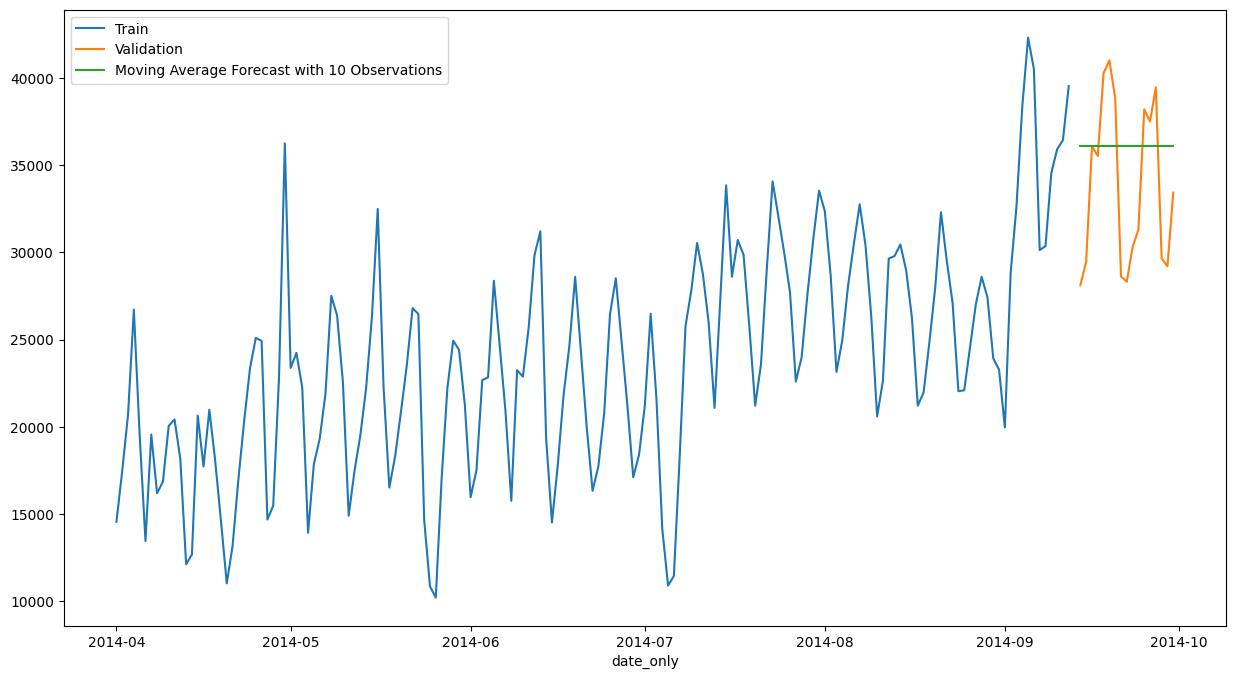

In [79]:
hat_avg = test_ts.copy()
hat_avg['moving_average_forecast'] = train_ts['Date/Time'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (15,5))
train_ts['Date/Time'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['Date/Time'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['moving_average_forecast'], label = 'Moving Average Forecast with 10 Observations')
plt.legend(loc = 'best')
plt.show()

# **Moving Average Forecast with 50 observations**

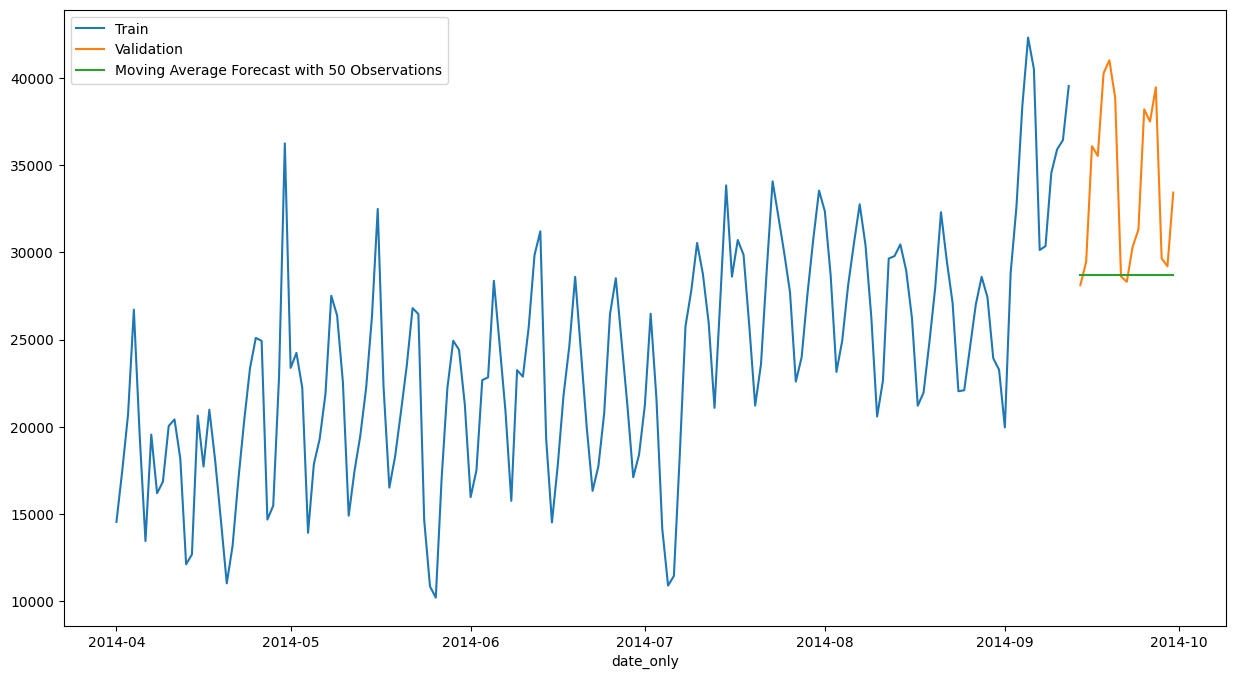

In [80]:
hat_avg = test_ts.copy()
hat_avg['moving_average_forecast'] = train_ts['Date/Time'].rolling(50).mean().iloc[-1]
plt.figure(figsize = (15,5))
train_ts['Date/Time'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['Date/Time'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['moving_average_forecast'], label = "Moving Average Forecast with 50 Observations")
plt.legend(loc = 'best')
plt.show()

## **Analysis Using Artificial Neural Networks (ANN)**

The merged_df uber_count is the grouping of the above dataset on hourly basis with time stamp of both date and time.

This merged_df will be used for the purpose of ANN analysis.`

In [81]:
uber_count=merged_df.groupby(pd.Grouper(key='date')).count()
uber_count= uber_count.drop(columns = ['date_only'])
print(uber_count.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260093 entries, 2014-04-01 00:11:00 to 2014-09-30 03:26:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Date/Time  260093 non-null  int64
dtypes: int64(1)
memory usage: 4.0 MB
None


## **Calculating 90% of the data**

In [82]:
round(0.9*len(uber_count))

234084

In [83]:
train = uber_count[:][:234084]             #90% of 260093
test = uber_count[:][234085:]

In [84]:
train.tail()

,Date/Time
date,
2014-09-24 09:50:00,16
2014-09-24 09:52:00,24
2014-09-24 09:56:00,15
2014-09-24 09:57:00,23
2014-09-24 09:58:00,21


In [85]:
test.head()

,Date/Time
date,
2014-09-24 10:00:00,15
2014-09-24 10:04:00,10
2014-09-24 10:05:00,17
2014-09-24 10:06:00,16
2014-09-24 10:08:00,16


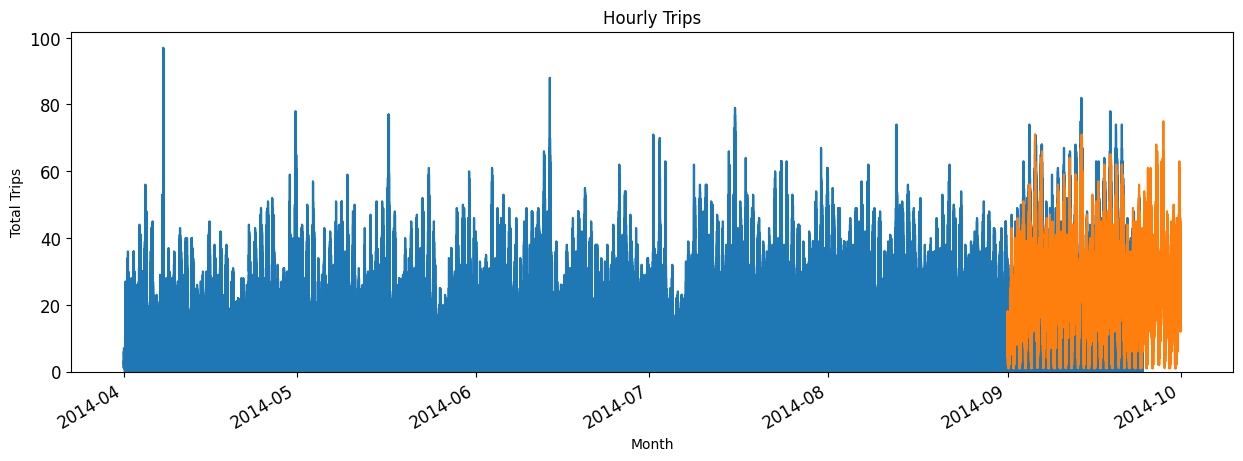

In [86]:
train['Date/Time'].plot(kind='area',figsize=(15,6), title= 'Hourly Trips', fontsize=14)
test['Date/Time'].plot(figsize=(15,5), title= 'Hourly Trips', fontsize=12)
plt.ylabel('Total Trips')
plt.xlabel('Month')
plt.show()

## **Visualizing Rolling Mean and Standard Deviation**

In [87]:
def test_stationary(timeseries):
    
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    
    #Plot rolling Statistics
    act = plt.plot(timeseries, color = "blue", label = "Actual")
    mean = plt.plot(rolmean, color = "brown", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)

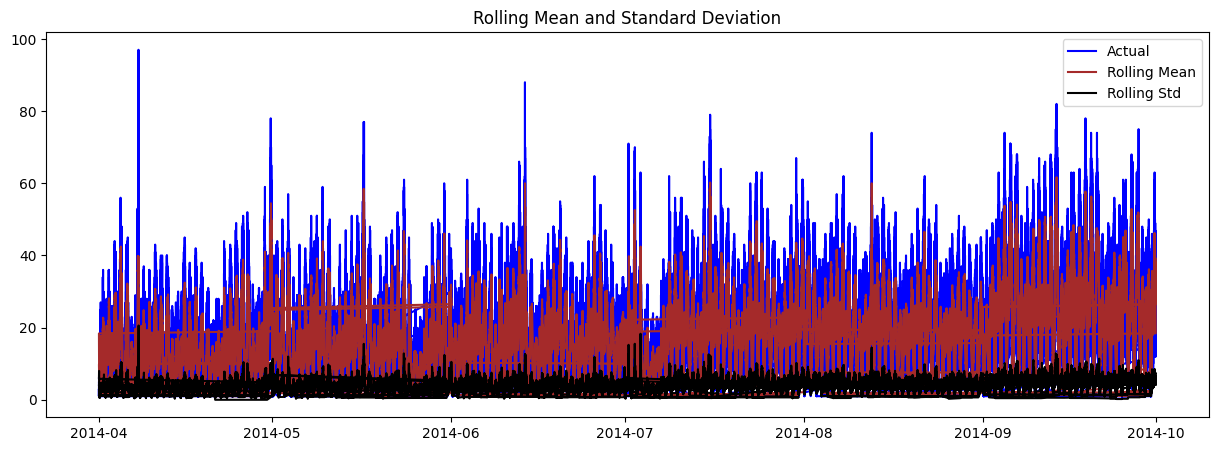

In [89]:
rcParams['figure.figsize']=(15,5)
test_stationary(uber_count['Date/Time'])

## **Scaling the dataset and splitting it**

In [92]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [97]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

In [95]:
K.clear_session()

## **Model Building Of ANN**

In [99]:
model = Sequential()
model.add(Dense(9, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/20
234083/234083 [==============================] - 198s 846us/step - loss: 0.0025
Epoch 2/20
234083/234083 [==============================] - 202s 861us/step - loss: 0.0026
Epoch 3/20
234083/234083 [==============================] - 200s 856us/step - loss: 0.0026
Epoch 4/20
234083/234083 [==============================] - 199s 849us/step - loss: 0.0026
Epoch 5/20
234083/234083 [==============================] - 198s 846us/step - loss: 0.0026
Epoch 6/20
234083/234083 [==============================] - 198s 844us/step - loss: 0.0026
Epoch 00006: early stopping


# **Prediction Of The Model**

In [100]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
rmse = sqrt(mean_squared_error(y_train,y_train_pred_ann))
print("Train : {:0.3f}".format(rmse))

rmse = sqrt(mean_squared_error(y_test,y_pred_test_ann))
print("Test : {:0.3f}".format(rmse))

model.save('Uber_Data_analysis_ANN')

Train : 0.089
Test : 0.093
INFO:tensorflow:Assets written to: Uber_Data_analysis_ANN/assets


In [101]:
model_ann = load_model('Uber_Data_analysis_ANN')    ##Saved Model

## **Prediction Of ANN**

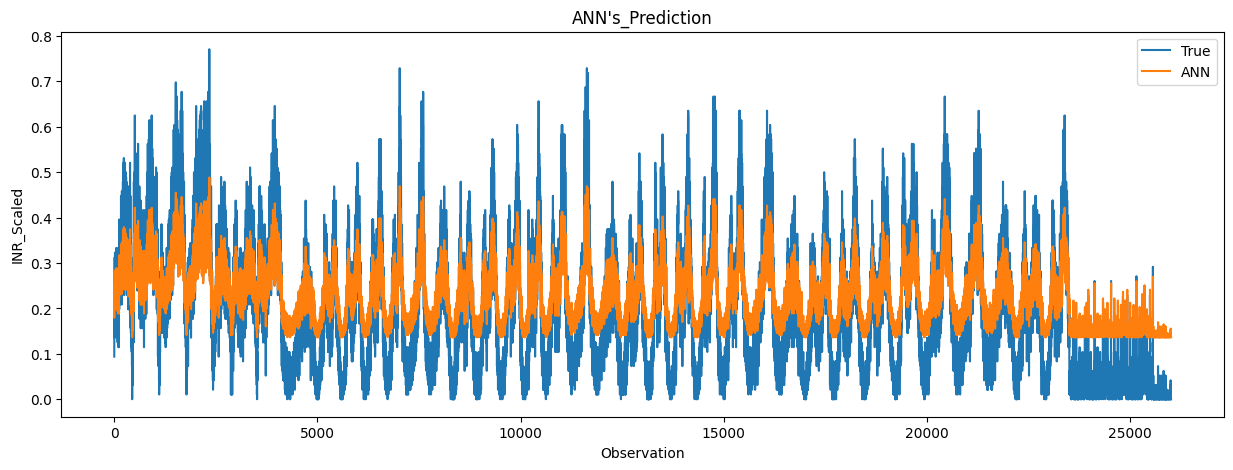

In [102]:
y_pred_test_ANN = model_ann.predict(X_test)
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


# **Calaculation Of Accuracy Score**

In [103]:
from sklearn import metrics
acc=metrics.r2_score(y_test,y_pred_test_ann)
print("Accuracy Score of Model: ",round(acc*100,2),'%')

Accuracy Score of Model:  54.87 %


# **Evaluation Of Error Score**

In [104]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
print('ANN: %f'%score_ann)

26007/26007 [==============================] - 19s 743us/step - loss: 0.0086
ANN: 0.008619


## **Conclusion** : Since the error square of ANN is very low, hence it is the most suitable model.